In [1]:
# import libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
import missingno as msno

# Pandas warning messages (optional)
pd.options.mode.chained_assignment = None  #default='warn'

# Plot options
import matplotlib.pyplot as plt
import seaborn as sns
sns.palplot(sns.color_palette('deep'))
sns.set_style("whitegrid")
%matplotlib inline

#### The dataset was downloaded from [insideairbnb](http://insideairbnb.com/get-the-data.html) for the city of Austin, Date Compiled on March 17th, 2020. 
#### Let's import the dataset and take a look at the first few observations.

In [2]:
# import dataset
df = pd.read_csv('data/listings.csv', low_memory=False)
df.head()

id                        listing_url       scrape_id last_scraped  \
0  2265  https://www.airbnb.com/rooms/2265  20200317143754   2020-03-17   
1  5245  https://www.airbnb.com/rooms/5245  20200317143754   2020-03-17   
2  5456  https://www.airbnb.com/rooms/5456  20200317143754   2020-03-17   
3  5769  https://www.airbnb.com/rooms/5769  20200317143754   2020-03-17   
4  6413  https://www.airbnb.com/rooms/6413  20200317143754   2020-03-17   

                                                name  \
0   Zen-East in the Heart of Austin (monthly rental)   
1  Eco friendly, Colorful, Clean, Cozy monthly share   
2          Walk to 6th, Rainey St and Convention Ctr   
3                                     NW Austin Room   
4                      Gem of a Studio near Downtown   

                                             summary  \
0  Zen East is situated in a vibrant & diverse mu...   
1  Situated in a vibrant & diverse multicultural ...   
2  Great central  location for walking to Convent...   
3                                                NaN   
4  Great studio apartment, perfect for couples or...   

                                               space  \
0  This colorful and clean 1923 house was complet...   
1  This green, colorful, clean and cozy house was...   
2  Cute Private Studio apartment located in Willo...   
3  Looking for a comfortable inexpensive room to ...   
4  !!!!! SXSW info !!!!! Presently open (again!) ...   

                                         description experiences_offered  \
0  Zen East is situated in a vibrant & diverse mu...                none   
1  Situated in a vibrant & diverse multicultural ...                none   
2  Great central  location for walking to Convent...                none   
3  Looking for a comfortable inexpensive room to ...                none   
4  Great studio apartment, perfect for couples or...                none   

                               neighborhood_overview  ... instant_bookable  \
0                                                NaN  ...                f   
1                                                NaN  ...                f   
2  My neighborhood is ideally located if you want...  ...                f   
3  Quiet neighborhood with lots of trees and good...  ...                f   
4  Travis Heights is one of the oldest neighborho...  ...                t   

  is_business_travel_ready          cancellation_policy  \
0                        f  strict_14_with_grace_period   
1                        f  strict_14_with_grace_period   
2                        f  strict_14_with_grace_period   
3                        f                     moderate   
4                        f  strict_14_with_grace_period   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             f                                f   
2                             f                                t   
3                             t                                t   
4                             f                                f   

   calculated_host_listings_count  \
0                               3   
1                               3   
2                               1   
3                               1   
4                               1   

   calculated_host_listings_count_entire_homes  \
0                                            2   
1                                            2   
2                                            1   
3                                            0   
4                                            1   

  calculated_host_listings_count_private_rooms  \
0                                            1   
1                                            1   
2                                            0   
3                                            1   
4                                            0   

   calculated_host_listings_

In [3]:
# shape
df.shape

(11668, 106)

The Airbnb dataset for Austin, TX consists of 106 features and 11668 observations. We need to look at these features closely and drop the ones that do not help our model to predict the rental prices. 

In [4]:
# specifying max_cols=df.shape[1] so we can look at the columns in df.info()
df.info(max_cols=df.shape[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11668 entries, 0 to 11667
Data columns (total 106 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11668 non-null  int64  
 1   listing_url                                   11668 non-null  object 
 2   scrape_id                                     11668 non-null  int64  
 3   last_scraped                                  11668 non-null  object 
 4   name                                          11668 non-null  object 
 5   summary                                       11244 non-null  object 
 6   space                                         9083 non-null   object 
 7   description                                   11461 non-null  object 
 8   experiences_offered                           11668 non-null  object 
 9   neighborhood_overview                         7937 non-null 

In [5]:
# ordering null columns based on the number of null values in each column
print('Columns with Null values by their count:')
df.isnull().sum().sort_values(ascending=False)[:25]

Columns with Null values by their count:


neighbourhood_group_cleansed    11668
thumbnail_url                   11668
medium_url                      11668
xl_picture_url                  11668
license                         11621
square_feet                     11476
monthly_price                   10931
weekly_price                    10793
notes                            6115
access                           4917
transit                          4370
host_about                       4099
interaction                      3862
house_rules                      3759
neighborhood_overview            3731
host_response_rate               3462
host_response_time               3462
security_deposit                 3100
host_acceptance_rate             2765
review_scores_location           2675
review_scores_value              2674
review_scores_communication      2670
review_scores_checkin            2670
review_scores_cleanliness        2669
review_scores_accuracy           2669
dtype: int64

Using MSNO to look at Misisng Values in 25 columns visually.

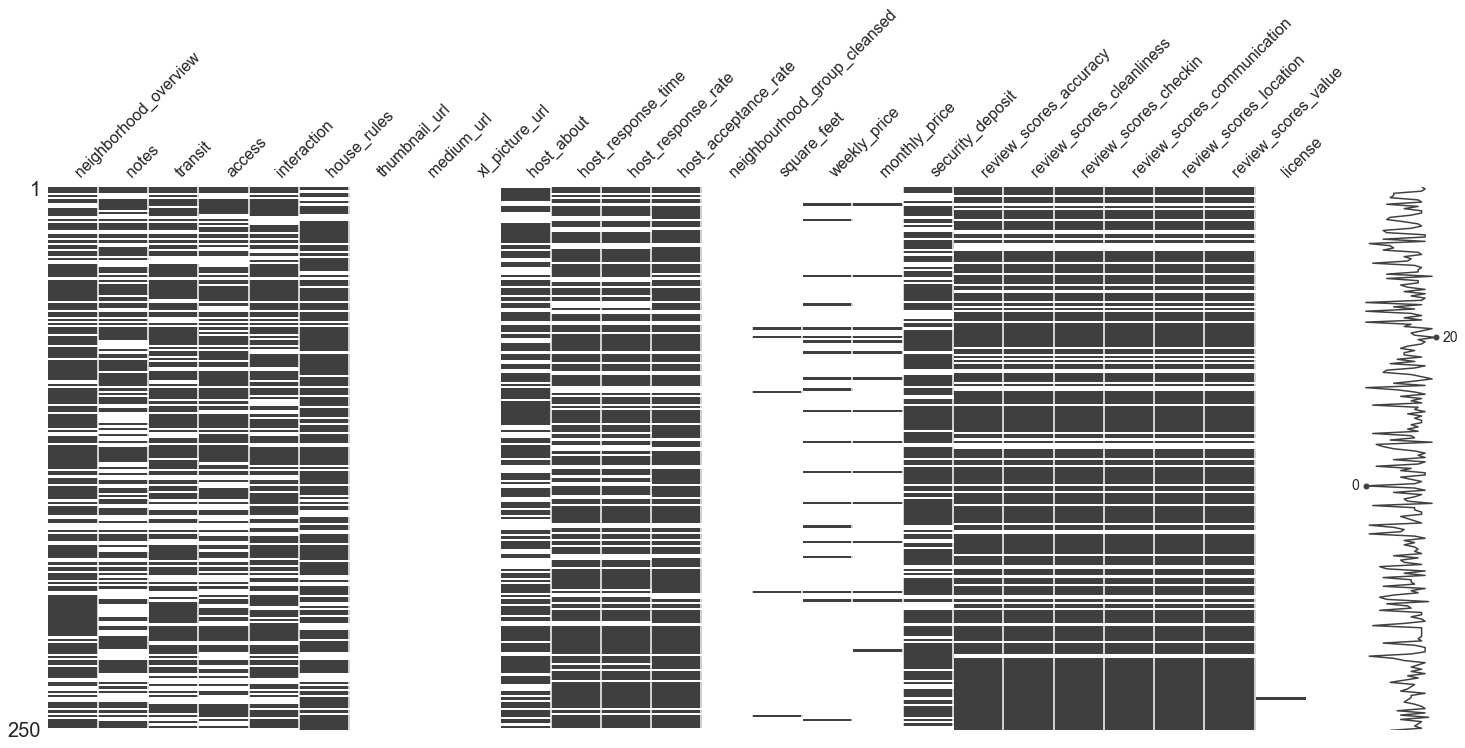

In [6]:
filtered_data = msno.nullity_filter(df, filter='bottom', n=25, p=0.999) # or filter='top'
msno.matrix(filtered_data.sample(250))

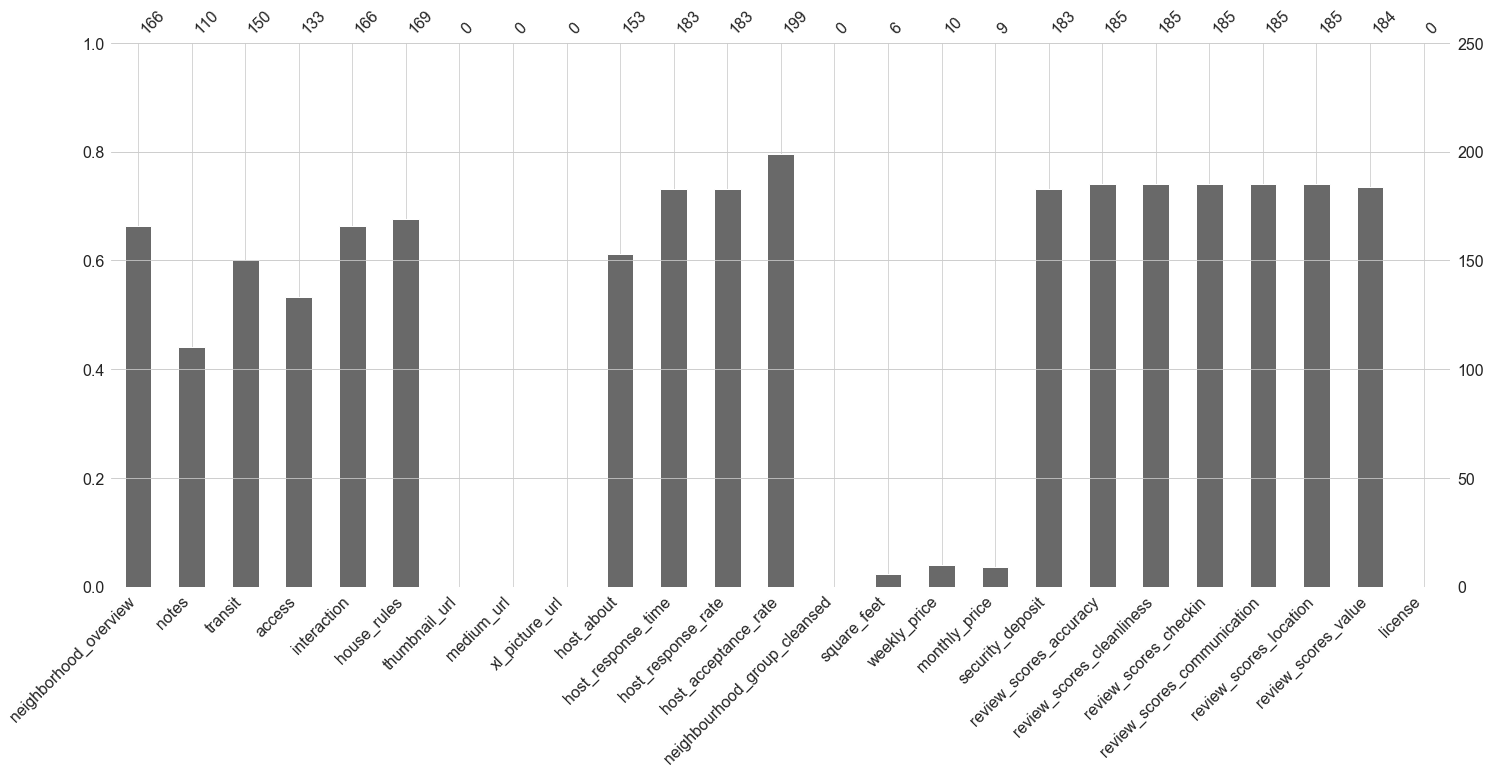

In [7]:
msno.bar(filtered_data.sample(250))

Features like 'square_feet', 'monthly_price' or 'weekly_price' have a lot of NULL values but we can use bedroom, bathroom, and accommodates data as a replacement for space size and also use 'price' for our prediction instead of 'monthly_price' or 'weekly_price'. 

In [8]:
df[['price','monthly_price', 'weekly_price']]

price monthly_price weekly_price
0      $225.00           NaN          NaN
1      $100.00           NaN          NaN
2       $95.00           NaN          NaN
3       $40.00           NaN      $160.00
4       $99.00     $1,900.00      $700.00
...        ...           ...          ...
11663   $60.00           NaN          NaN
11664   $40.00           NaN          NaN
11665   $40.00           NaN          NaN
11666   $45.00           NaN          NaN
11667   $35.00           NaN          NaN

[11668 rows x 3 columns]

In [9]:
# Looking at describe() to get some insights on price and other numerical values
df.describe()

id     scrape_id  thumbnail_url  medium_url  xl_picture_url  \
count  1.166800e+04  1.166800e+04            0.0         0.0             0.0   
mean   2.372608e+07  2.020032e+13            NaN         NaN             NaN   
std    1.314942e+07  2.511826e+00            NaN         NaN             NaN   
min    2.265000e+03  2.020032e+13            NaN         NaN             NaN   
25%    1.275706e+07  2.020032e+13            NaN         NaN             NaN   
50%    2.361444e+07  2.020032e+13            NaN         NaN             NaN   
75%    3.599878e+07  2.020032e+13            NaN         NaN             NaN   
max    4.293155e+07  2.020032e+13            NaN         NaN             NaN   

            host_id  host_listings_count  host_total_listings_count  \
count  1.166800e+04         11666.000000               11666.000000   
mean   7.673078e+07            66.963398                  66.963398   
std    8.628560e+07           281.215856                 281.215856   
min    2.300000e+01             0.000000                   0.000000   
25%    8.761906e+06             1.000000                   1.000000   
50%    3.939813e+07             1.000000                   1.000000   
75%    1.185659e+08             4.000000                   4.000000   
max    3.416244e+08          2016.000000                2016.000000   

       neighbourhood_cleansed  neighbourhood_group_cleansed  ...  \
count            11668.000000                           0.0  ...   
mean             78722.143469                           NaN  ...   
std                 20.689544                           NaN  ...   
min              78701.000000                           NaN  ...   
25%              78704.000000                           NaN  ...   
50%              78717.000000                           NaN  ...   
75%              78744.000000                           NaN  ...   
max              78759.000000                           NaN  ...   

       review_scores_cleanliness  review_scores_checkin  \
count                8999.000000            8998.000000   
mean                    9.607512               9.838964   
std                     0.838195               0.611808   
min                     2.000000               2.000000   
25%                     9.000000              10.000000   
50%                    10.000000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000              10.000000   

       review_scores_communication  review_scores_location  \
count                  8998.000000             8993.000000   
mean                      9.848188                9.779162   
std                       0.600158                0.615760   
min                       2.000000                2.000000   
25%                      10.000000               10.000000   
50%                      10.000000               10.000000   
75%                      10.000000               10.000000   
max                      10.000000               10.000000   

       review_scores_value  calculated_host_listings_count  \
count          8994.000000                    11668.000000   
mean              9.587725                       13.572506   
std               0.794404                       41.256138   
min               2.000000                        1.000000   
25%               9.000000                        1.000000   
50%              10.000000                        1.000000   
75%              10.000000                        4.000000   
max              10.000000                      248.000000   

       calculated_host_listings_count_entire_homes  \
count                                 11668.000000   
mean                                     12.477288   
std                                      41.041238   
min                                       0.000000   
25%                                       1.000000   
50%                                       1.000000   
75%            

Notice that 'price' is not included on the describe() above! Let's investigate why 'price' did not show up!

In [10]:
# describe for price
df['price'].head()

0    $225.00
1    $100.00
2     $95.00
3     $40.00
4     $99.00
Name: price, dtype: object

'price' is type object and needs to be transformed to the correct data type.

In [11]:
# Convert price to from currency to float
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].astype(float, 2)

In [12]:
# Verify price type is float
df['price'].head()

0    225.0
1    100.0
2     95.0
3     40.0
4     99.0
Name: price, dtype: float64

In [13]:
df.price.describe()

count    11668.000000
mean       484.237830
std       1480.352627
min          0.000000
25%         80.000000
50%        149.000000
75%        300.000000
max      14298.000000
Name: price, dtype: float64

Defined a mask for price based on below 25% quartile as 'low', below 50% as 'med' and the rest was set as 'high'

In [14]:
price_bins=[]
for price in df.price:
    if price < 81:
        price_bins.append('low')
    if price < 150:
        price_bins.append('med')
    else:
        price_bins.append('high')

In [15]:
[[x,price_bins.count(x)] for x in set(price_bins)]

[['high', 5770], ['med', 5898], ['low', 2944]]

In [16]:
df['price_bins'] = pd.Series(price_bins)

In [17]:
df[['price', 'price_bins']]

price price_bins
0      225.0       high
1      100.0        med
2       95.0        med
3       40.0        low
4       99.0        med
...      ...        ...
11663   60.0        med
11664   40.0       high
11665   40.0       high
11666   45.0        med
11667   35.0        med

[11668 rows x 2 columns]

med     4750
high    4598
low     2320
Name: price_bins, dtype: int64


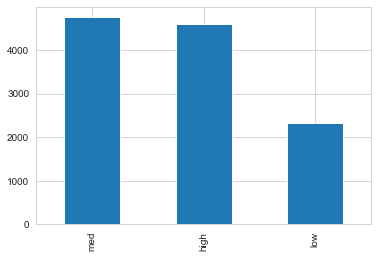

In [18]:
print(df['price_bins'].value_counts())
df['price_bins'].value_counts().plot(kind='bar');

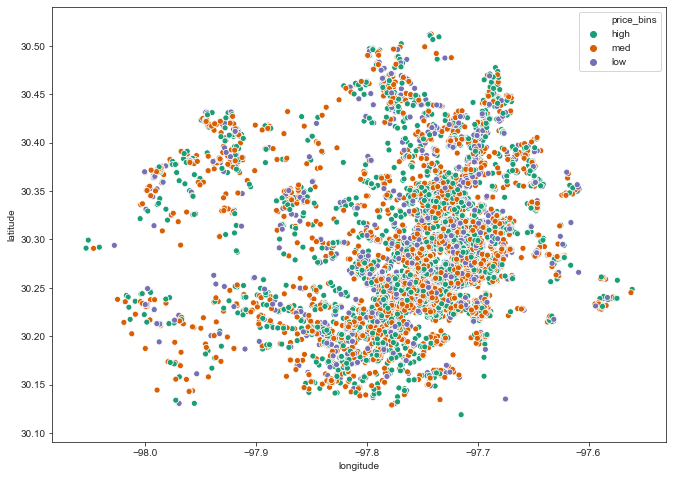

In [19]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.scatterplot(data=df, x='longitude', y='latitude', hue='price_bins', palette='Dark2', ax=ax);

Entire home/apt    8848
Private room       2610
Shared room         159
Hotel room           51
Name: room_type, dtype: int64


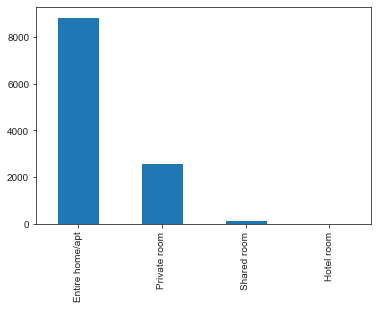

In [20]:
# value counts by room_type
print(df['room_type'].value_counts())
df['room_type'].value_counts().plot(kind='bar');

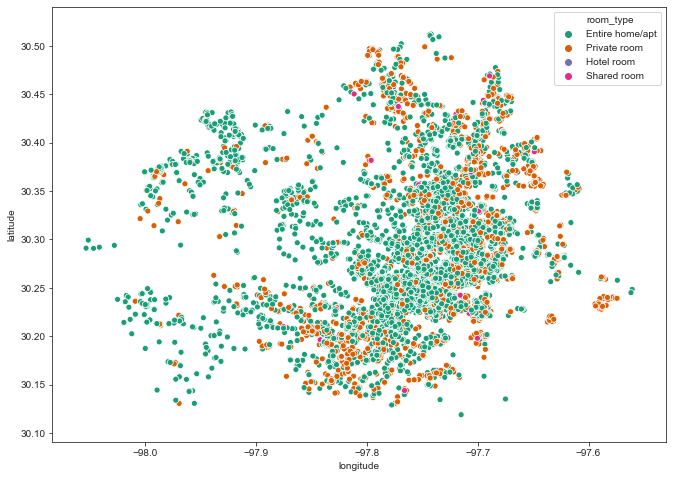

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.scatterplot(data=df, x='longitude', y='latitude', hue='room_type', palette='Dark2', ax=ax);

In [30]:
lat_long= df[['latitude', 'longitude']]

In [31]:
lat_long

latitude  longitude
0      30.277500 -97.713980
1      30.275770 -97.713790
2      30.261120 -97.734480
3      30.456970 -97.784220
4      30.248290 -97.737260
...          ...        ...
11663  30.252145 -97.749723
11664  30.229216 -97.735202
11665  30.233525 -97.732541
11666  30.239666 -97.741078
11667  30.283632 -97.691241

[11668 rows x 2 columns]

East Downtown          1087
Downtown                742
Travis Heights          462
University of Texas     434
East Riverside          374
                       ... 
Gateway                  22
Mesa Park                12
Cat Mountian             11
Walnut Creek              7
Canyon Mesa               6
Name: neighbourhood, Length: 78, dtype: int64


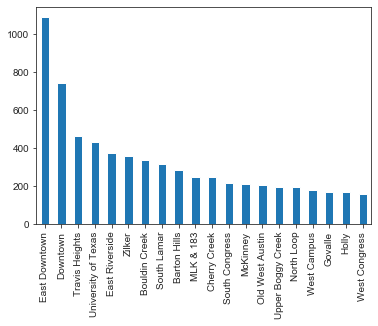

In [32]:
# value counts 
print(df['neighbourhood'].value_counts())
df['neighbourhood'].value_counts()[:20].plot(kind='bar');

In [33]:
df[['neighbourhood_cleansed', 'neighbourhood', 'neighbourhood_group_cleansed']]

neighbourhood_cleansed      neighbourhood  neighbourhood_group_cleansed
0                       78702      East Downtown                           NaN
1                       78702      East Downtown                           NaN
2                       78702      East Downtown                           NaN
3                       78729  SW Williamson Co.                           NaN
4                       78704     Travis Heights                           NaN
...                       ...                ...                           ...
11663                   78704     South Congress                           NaN
11664                   78741        Parker Lane                           NaN
11665                   78741     East Riverside                           NaN
11666                   78704     Travis Heights                           NaN
11667                   78721           Downtown                           NaN

[11668 rows x 3 columns]

In [ ]:
columns_list = ['room_type', 'price', 'accommodates', 'bathrooms', 'bedrooms',  
                'host_is_superhost', 'neighbourhood_cleansed', 'longitude', 'latitude', 
                'number_of_reviews', 'availability_365', 'reviews_per_month', 
                'review_scores_rating', 'minimum_nights']

df = df[columns_list]

In [ ]:
df.head()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

axes[0,0].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['price']), cmap='RdPu', alpha=0.8)
axes[0,0].set_title('Neighbourhood Group')

axes[0,1].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['reviews_per_month']), cmap='GnBu', alpha=0.8)
axes[0,1].set_title('Reviews per month')

axes[0,2].scatter(x=df['longitude'], y=df['latitude'], c=df['availability_365'], cmap='YlGn', alpha=0.6)
axes[0,2].set_title('Availability 365')

axes[1,0].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['number_of_reviews']), cmap='RdPu', alpha=0.6)
axes[1,0].set_title('Number of reviews')

axes[1,1].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['minimum_nights']), cmap='GnBu', alpha=0.6)
axes[1,1].set_title('Minimum Nights')

axes[1,2].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['accommodates']), cmap='YlGn', alpha=0.6)
axes[1,2].set_title('Accommodations')

plt.show()

Noting for cleanup:

Price needs to be converted to float
Missing NaN values need data imputed or rows removed
Categorical columns need to be converted to dummy variables (get_dummies)
To continue the data exploration, I need to perform some cleanup procedures. In the data preparation section that follows, I'll create a cleanup function to put these cleaning steps together.

In [ ]:
print("Dataset has {} row entries.".format(df.shape[0]))

In [ ]:
# What are the distribution of rental prices
fig, ax = plt.subplots()
ax.hist(df['price'], bins=50)
ax.set_yscale("log", nonposy='clip')
plt.show();

There are some oddly high prices (> $2000) that I want to examine. However, if the rental is a large proporty it would not be fair to discriminate based on price alone. I'll look at price per person (price / accommodates) to look for outliers.

In [ ]:
# Create 'price_per_person' feature
df['price_per_person'] = df['price']/df['accommodates']

df['price_per_person'].value_counts().sort_index(ascending=False).head(10)

In [ ]:
df.loc[df['price_per_person'] > 1000.00]

Upon reviewing the url listings, the houses listed as with extreme prices looked like automated (or unmaintained) listings with little to no reviews with some being incorrectly priced at the time of the source data scrape. I'm opting to remove them from this analysis since they don't pass my common sense as a consumer. However, it would be intersting to examine other popular cities to see if they had similar outliers.

In [ ]:
# remove rows with > $1000 per person
df = df.loc[df['price_per_person'] <= 1000.00]

# verify removal
df['price_per_person'].value_counts().sort_index(ascending=False).head()

In [ ]:
df.describe()

The review ratings (review_scores_rating) are missing a lot of data. However, due to the small size of the data set, I'll opt to fill the missing values of the ratings scores at the cost of diluting the ratings feature importance. Before I do this, I'll save a copy of the DataFrame in it's current state since I want to look at a plot of price vs. rating later.

In [ ]:
# Imputed mean value of review scores to missing data in review_scores_rating feature
print("Filling NaN 'review_scores_rating' with {:.3f}.".format(df['review_scores_rating'].mean()))
df['review_scores_rating'].fillna((df['review_scores_rating'].mean()), inplace=True)

The bathrooms feature is missing some data. I'll update the NaNs based on a rough guess that for every 2 people the rental can accommodate, there is 1 bathroom.

In [ ]:
df[df['bathrooms'].isnull()].head()

In [ ]:
# Bathrooms is getting scaled later, so I do not care about making it a discrete value
# Also 0.5 is commonly known as a 'half-bath'
df['bathrooms'].fillna((df['accommodates']/2), inplace=True)

In [ ]:
df.info()

In [ ]:
df.loc[[120]]

In [ ]:
df.isnull().sum()

In [ ]:
df[df['bedrooms'].isnull()].head()

In [ ]:
df[df['bathrooms'] == 0].count()

In [ ]:
# Drop the few remaining rows with missing values
df.dropna(inplace=True)

The data set severly lacks in samples for larger houses. I'm going to remove some of the extreme rows for these cases since I'm more interested in examining typically sized houses. Another study could be done for very large rental using data from all over the US.

In [ ]:
df['bathrooms'].value_counts().sort_index(ascending=False)

In [ ]:
df.groupby('bathrooms').price.median()

In [ ]:
df['accommodates'].value_counts().sort_index(ascending=False)

In [ ]:
df.groupby('accommodates').price.mean()

In [ ]:
# Remove extremely large rental listing due to low samples
df = df.loc[df['bathrooms'] <= 8]
df = df.loc[df['accommodates'] <= 16]

In [ ]:
plt.plot(df.groupby('number_of_reviews').review_scores_rating.mean());

### Verify Data Quality
Need to verify that price is a float, review_scores_rating are not missing any values.

In [ ]:
df.info()

### Data Preparation 
The data preparation process in the CRISP-DM cycle consists of:

##### Select your data
Clean your data
Construct required data
Integrate data (not required for this project)
Select your data
This is the stage of the project where you decide on the data that you're going to use for analysis. [source]. To answer the business questions posed at the beginning, I'm choosing to keep the following features:

'price' - target feature for the business questions
'room_type' - property type: house, private room, shared room
'accommodates' - property size metric
'bathrooms' - property size metric
'bedrooms' - property size metric
'host_is_superhost' - Airbnb host status
'neighbourhood_cleansed' - Location, ZIP code
'number_of_reviews' - Review metric
'review_scores_rating' - Review metric
'minimum_nights' - length of stay metric
#### Clean your data
This task involves raise the data quality to the level required by the analysis techniques that you've selected [source]. I'm creating a 'cleaning' function so that I don't have to repeat the above steps everytime I load the notebook.

In [ ]:
def clean_listings_data(csv, review_impute = True):
    '''
    Takes a listings.csv file (insideairbnb.com) for a particular
    city and outputs a cleaned the data frame 
    for the feature_list defined below. Note that the feature_list
    is hardcoded since the cleaning operations may not work for a
    different set of features. 
    
    Input:
    csv - insideairbnb.com listings.csv 
    review_impute - create additional DataFrames with no or '0' imputation 
                    for NaNs in the 'review_scores_rating' column
    
    Output:
    df - Cleaned DataFrame, used for prediction model
    df_no_impute - DataFrame with no imputed values on 'review_scores_rating'
    df_zeros_impute - DataFrame with integer '0' imputed values on 'review_scores_rating'
    '''
    
    # Import and load data
    df = pd.read_csv('data/listings.csv', low_memory=False)
    
    # Select features to keep in DataFrame
    feature_list = ['room_type', 'price', 'accommodates', 'bathrooms', 
                    'bedrooms', 'host_is_superhost', 'neighbourhood_cleansed', 
                    'number_of_reviews', 'review_scores_rating', 'minimum_nights']
    df = df[feature_list]
    
    # Convert price to from currency to float
    df['price'] = df['price'].str.replace('$', '')
    df['price'] = df['price'].str.replace(',', '')
    df['price'] = df['price'].astype(float)
    
    # Create feature for price per person
    df['price_per_person'] = df['price']/df['accommodates']
    
    # Remove rows with > $1000 per person
    df = df.loc[df['price_per_person'] <= 1000.00]
    
    # df for specific plots - need data before 'review_scores_rating' imputation
    df_no_impute = df[['review_scores_rating', 'price', 'price_per_person', 
                    'number_of_reviews', 'bathrooms', 'bedrooms', 'accommodates']].copy()
    df_zeros_impute = df_no_impute.copy()
    df_no_impute.dropna(inplace=True)
    df_zeros_impute['review_scores_rating'].fillna(0, inplace=True)
    df_zeros_impute.dropna(inplace=True)

    # Imputed mean value of review scores to missing data in review_scores_rating feature
    df['review_scores_rating'].fillna((df['review_scores_rating'].mean()), inplace=True)
    
    # Bathrooms is getting scaled later, so I do not care about making it a discrete value
    df['bathrooms'].fillna((df['accommodates']/4), inplace=True)
    
    # Drop the few remaining rows with missing values
    df.dropna(inplace=True)
    
    # Remove extremely large rental listing due to low samples
    df = df.loc[df['bathrooms'] <= 8]
    df = df.loc[df['accommodates'] <= 16]
    
    print('clean_listings_data: Cleaning Complete')
    
    if review_impute:
        return df, df_no_impute, df_zeros_impute
    else:
        return df

# Run cleanup function
df, df_no_impute, df_zeros_impute = clean_listings_data('data/listings.csv')

### Construct required data
This task includes constructive data preparation operations such as the production of derived attributes or entire new records, or transformed values for existing attributes. source

Now that the DataFrame is cleaned, I want to sort all of the ZIP codes for Austin the into several regions to simplify the analysis. This could be easily updated for anyone who wants to redraw my subjective boundaries. Also, for a different city, the following would need to be redone with the appropriate ZIP codes.

Additionally, I need to create dummy variables and scale the features for the regression models.

In [ ]:
# Compress zipcode into 5 regions for 1 hot encoding
zip_central = [78701, 78702, 78703, 78704, 78705, 78712, 78722]
zip_north = [78726, 78727, 78728, 78729, 78731, 78750, 78751,  
             78756, 78758, 78759, 78757]
zip_west = [78730, 78732, 78733, 78734, 78735, 78736, 78738, 78746]
zip_south = [78737, 78739, 78745, 78749, 78748, 78742]
zip_east = [78717, 78719, 78721, 78723, 78724, 78725, 78741, 
            78744, 78747, 78752, 78753, 78754]

map_dict = {}
str_dict = {0: 'Central', 1: 'North', 2: 'West', 3: 'South', 4: 'East'}
area_list = [zip_central, zip_north, zip_west, zip_south, zip_east]

# Create a dict for the pandas map function to convert zip into region
for i in range(len(area_list)):
    for zipcode in area_list[i]:
        map_dict[zipcode] = str_dict[i]   

# Replace 'neighbourhood_cleansed' with 'region' feature
df['region'] = df['neighbourhood_cleansed'].map(map_dict)
df.drop(['neighbourhood_cleansed'], axis=1, inplace=True)

In [ ]:
features_list = ['room_type', 'bathrooms', 'bedrooms', 'accommodates', 
                 'host_is_superhost',  'region', 'review_scores_rating', 'number_of_reviews']

# Create features and price DFs for sklearn inputs
features = df[features_list].copy()   # 'X'
price = df['price'].copy()            # 'y'

In [ ]:
# Create dummy variables for 'room type', 'superhost' and 'region'
features = pd.get_dummies(features)
features.head()

In [ ]:
# Scale the quantitative features
# Note: using RobustScaler resulted in similar r2 results
scaler = MinMaxScaler()
numerical = ['bathrooms', 'bedrooms', 'review_scores_rating', 'accommodates', 'number_of_reviews']
features_scaled = features.copy()
features_scaled[numerical] = scaler.fit_transform(features_scaled[numerical])

In [ ]:
features_scaled.head()

In [ ]:
features_scaled.to_csv('data/listings_scaled.csv')